# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### My questions

- What is the reward/difficulty meaning for a _discount_ offer? Is it the percentage / minimum transaction amount?
- What is __t0__? It could be useful to understand when the offer arrived compared to the _become_member_on_.

In [64]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Step 1 - Data preparation

## Portfolio

This dataset is pretty straightforward, we have a list of 10 offers with the specific informations.

_Data preparation:_
- Create a set of flags to split the _channels_ feature.
- Create a _channels_ counter.

In [3]:
print(portfolio.shape)
portfolio

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
for channel in ['web', 'email', 'mobile', 'social']:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
portfolio['channels_num'] = portfolio['channels'].apply(lambda x: len(x))

portfolio

,reward,channels,difficulty,duration,offer_type,id,web,email,mobile,social,channels_num
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,3
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,4
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,3
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,2
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,4
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,3
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,3


## Profile

This dataset has information about customers.

_Data preparation:_
- Transform the _became_member_on_ feature into a date feature.
- Analyse the missing features and eventually apply a transformation.

In [5]:
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
cust = len(profile['id'].unique().tolist())
print(f'On {len(profile)} records we have {cust} customers')

On 17000 records we have 17000 customers


In [7]:
# To transform the feature, we create a new column
profile['member_on'] = pd.to_datetime(profile['became_member_on'].astype(str)).dt.date

profile.head(10)

,gender,age,id,became_member_on,income,member_on
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018-04-26
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN,2017-09-25
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN,2017-10-02
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,2018-02-09
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN,2016-11-22


In [8]:
profile.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,14825,3,M,8484,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,17000,NaN,NaN,NaN,62.5314,26.7386,18,45,58,73,118
id,17000,17000,32e149f18abe4a0a8555707ea9e99749,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
became_member_on,17000,NaN,NaN,NaN,2.0167e+07,11677.5,2.01307e+07,2.01605e+07,2.01708e+07,2.01712e+07,2.01807e+07
income,14825,NaN,NaN,NaN,65405,21598.3,30000,49000,64000,80000,120000
member_on,17000,1716,2017-12-07,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are some missing in _gender_ and _income_: let's dive in this subset.

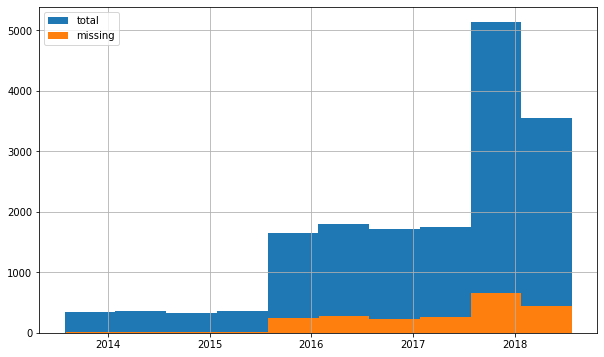

In [9]:
plt.figure(figsize=(10, 6))
profile.member_on.hist()
profile.loc[profile.gender.isnull(), 'member_on'].hist()

plt.legend(['total', 'missing'])

plt.show()

In [10]:
profile.loc[profile['gender'].isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


It seems like there's no particular time trend in missing data, and _income_ is always null and _age_ is always 118. Since we basically have no info on these profiles, let's drop them.

In [11]:
profile = profile.loc[profile['gender'].isnull() == False]

print(profile.shape)
profile.head(10)

(14825, 6)


,gender,age,id,became_member_on,income,member_on
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2018-04-26
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,2018-02-09
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,2017-11-11
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,20170911,57000.0,2017-09-11
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,46000.0,2014-02-13
15,F,62,31dda685af34476cad5bc968bdb01c53,20160211,71000.0,2016-02-11
16,M,49,62cf5e10845442329191fc246e7bcea3,20141113,52000.0,2014-11-13
18,M,57,6445de3b47274c759400cd68131d91b4,20171231,42000.0,2017-12-31


## Transcript

This dataframe contains the list of all actions on offers and transactions, with the relative information about money and time.

_Data preparation:_
- Analyse the _value_ feature and extract the information
- Reconstruct the customer journey, from receiving the offer to the (eventual) transaction

In [12]:
print(transcript.shape)
transcript.head(10)

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [13]:
keys = transcript.value.apply(lambda x: str(list(x.keys())))
keys.unique()

array(["['offer id']", "['amount']", "['offer_id', 'reward']"],
      dtype=object)

The value could be the **offer_id**, the **amount** and the **reward**: this last one is always with the _offer_id_.

In [14]:
pd.crosstab(keys, transcript['event'])

event,offer completed,offer received,offer viewed,transaction
value,,,,
['amount'],0,0,0,138953
['offer id'],0,76277,57725,0
"['offer_id', 'reward']",33579,0,0,0


In [15]:
# We create columns for each of these values, dropping the original column
for k in ['reward', 'amount']:
    transcript[k] = transcript['value'].apply(lambda x: x[k] if k in x else None)
    
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
transcript.drop('value', 1, inplace=True)
transcript.tail(10)

,person,event,time,reward,amount,offer_id
306524,d613ca9c59dd42f497bdbf6178da54a7,transaction,714,NaN,25.14,None
306525,eec70ab28af74a22a4aeb889c0317944,transaction,714,NaN,43.58,None
306526,24f56b5e1849462093931b164eb803b5,transaction,714,NaN,22.64,None
306527,24f56b5e1849462093931b164eb803b5,offer completed,714,2.0,NaN,fafdcd668e3743c1bb461111dcafc2a4
306528,5ca2620962114246ab218fc648eb3934,transaction,714,NaN,2.20,None
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,None
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,None
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,None
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,None
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,NaN,4.05,None


What is the history of a single customer? How many customers do we have? How many record has a customer?

In [16]:
cust = len(transcript['person'].unique().tolist())
print(f'On {len(transcript)} records we have {cust} customers')

On 306534 records we have 17000 customers


In [17]:
cust_list = transcript.groupby('person')['time'].count()
cust_list.sort_values(ascending=False)

person
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
                                    ..
22617705eec442e0b7b43e5c5f56fb17     2
df9fc9a86ca84ef5aedde8925d5838ba     2
3a4e53046c544134bb1e7782248631d1     2
e63e42480aae4ede9f07cac49c8c3f78     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: time, Length: 17000, dtype: int64

The number of events per customer ranges from only 1 to 51!

In [18]:
asd = pd.merge(transcript.loc[transcript['event'] == 'offer completed'],
               transcript.loc[transcript['event'] == 'transaction', ['person', 'event', 'time']],
               on=['person', 'time'])

print(asd.shape, sum(transcript['event'] == 'offer completed'))

(33579, 7) 33579


For each _offer completed_ there is a _transaction_ at the same time.

In [19]:
asd = pd.merge(transcript.loc[transcript['event'] == 'offer viewed'].reset_index(),
               transcript.loc[transcript['event'] == 'offer received', ['person', 'time', 'offer_id']],
               on=['person', 'offer_id'])

print(len(asd['index'].unique()), sum(transcript['event'] == 'offer viewed'))

57725 57725


For each _viewed_ offer there is a record with the relative _received_ offer.

In [20]:
asd = pd.merge(transcript.loc[transcript['event'] == 'offer completed'].reset_index(),
               transcript.loc[transcript['event'] == 'offer viewed', ['person', 'time', 'offer_id']],
               on=['person', 'offer_id'])

print(len(asd['index'].unique()), sum(transcript['event'] == 'offer completed'))

28724 33579


As expected, there are some _offers completed_ without the relative _view_, so they are completed by chance. These are **false positive** and we have to remove them from the analysis.

To better analyse the completion of the offers, we create a new dataframe recreating the entire funnel of customer's conversion:
- At first, we join the offer received with the eventual view by the customer
- Then, we follow the same approach to add information about conversion (_offer completed_)
- Finally, for each conversion, we join the record about the related _transaction_

In [21]:
# At first, let's join togheter the received offer with the relative (eventual) view
views = pd.merge(transcript.loc[transcript['event'] == 'offer received', ['person', 'offer_id', 'time']],
                 transcript.loc[transcript['event'] == 'offer viewed', ['person', 'offer_id', 'time']],
                 on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

# We have to be sure to take the reception BEFORE the view (or when there's no view)
views = views.loc[(views['time_viewed'] >= views['time_received']) | (views['time_viewed'].isnull())]

# Then we take the NEAREST reception before the view
# We concatenate with the "missing view" dataframe portion, since aggregation results in a drop of these records
views = pd.concat((views.groupby(['person', 'offer_id', 'time_viewed']).agg({'time_received': 'max'}).reset_index(),
                  views.loc[views['time_viewed'].isnull()]),
                  axis=0, sort=True)

print(views.shape)
views.head()

(73717, 4)


,offer_id,person,time_received,time_viewed
0,3f207df678b143eea3cee63160fa8bed,0009655768c64bdeb2e877511632db8f,336,372.0
1,5a8bc65990b245e5a138643cd4eb9837,0009655768c64bdeb2e877511632db8f,168,192.0
2,f19421c1d4aa40978ebb69ca19b0e20d,0009655768c64bdeb2e877511632db8f,408,456.0
3,fafdcd668e3743c1bb461111dcafc2a4,0009655768c64bdeb2e877511632db8f,504,540.0
4,f19421c1d4aa40978ebb69ca19b0e20d,00116118485d4dfda04fdbaba9a87b5c,168,216.0


In [22]:
# Same reasoning joining the info about offer completion
comp = pd.merge(views,
                transcript.loc[transcript['event'] == 'offer completed', ['person', 'offer_id', 'time', 'reward']],
                on=['person', 'offer_id'], how='left').rename(columns={'time': 'time_completed'})

# When the completion time is AFTER the view time, we force the value to null
comp.loc[(comp['time_viewed'].isnull()) | (comp['time_viewed'] > comp['time_completed']), ['time_completed', 'reward']] = (np.nan, np.nan)
comp.drop_duplicates(inplace=True)

comp = pd.concat(
    (comp.groupby(['person', 'offer_id', 'time_completed', 'reward']).agg({'time_viewed': 'max', 'time_received': 'max'}).reset_index(),
     comp.loc[comp['time_completed'].isnull()]),
    axis=0, sort=True
)


print(comp.shape)
comp.head()

(76673, 6)


,offer_id,person,reward,time_completed,time_received,time_viewed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0011e0d4e6b944f998e987f904e8c1e5,5.0,576.0,408,432.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,0011e0d4e6b944f998e987f904e8c1e5,3.0,252.0,168,186.0
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,0011e0d4e6b944f998e987f904e8c1e5,5.0,576.0,504,516.0
3,4d5c57ea9a6940dd891ad53e9dbe8da0,0020c2b971eb4e9188eac86d93036a77,10.0,510.0,408,426.0
4,fafdcd668e3743c1bb461111dcafc2a4,0020c2b971eb4e9188eac86d93036a77,2.0,54.0,0,12.0


In [23]:
# Now we join the information about the relative transaction
journey = pd.merge(comp,
                   transcript.loc[transcript['event'] == 'transaction', ['person', 'time', 'amount']],
                   left_on=['person', 'time_completed'], right_on=['person', 'time'], how='outer').rename(columns={'time': 'time_transaction'})
journey = journey[['person', 'offer_id', 'time_received', 'time_viewed', 'time_completed', 'time_transaction', 'amount', 'reward']]

print(journey.shape)
journey.head(10)

(192096, 8)


,person,offer_id,time_received,time_viewed,time_completed,time_transaction,amount,reward
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,432.0,576.0,576.0,22.05,5.0
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,516.0,576.0,576.0,22.05,5.0
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,186.0,252.0,252.0,11.93,3.0
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408.0,426.0,510.0,510.0,17.24,10.0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0.0,12.0,510.0,510.0,17.24,2.0
5,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0.0,12.0,54.0,54.0,17.63,2.0
6,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,168.0,222.0,222.0,11.65,3.0
7,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,582.0,600.0,600.0,10.32,5.0
8,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,336.0,348.0,378.0,378.0,14.53,5.0
9,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,168.0,300.0,384.0,384.0,3.66,2.0


In [53]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,web,email,mobile,social,channels_num
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,3
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,4
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,3
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,2
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,4
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,3
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,3


In [60]:
# Join offer info
tmp = pd.merge(journey,
               portfolio.drop('channels', 1).rename(columns={'reward': 'pot_reward', 'id': 'offer_id'}),
               on='offer_id', how='left')
tmp.head()

,person,offer_id,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,difficulty,duration,offer_type,web,email,mobile,social,channels_num
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,432.0,576.0,576.0,22.05,5.0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,2.0
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,516.0,576.0,576.0,22.05,5.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,3.0
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,186.0,252.0,252.0,11.93,3.0,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0,4.0
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408.0,426.0,510.0,510.0,17.24,10.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,4.0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0.0,12.0,510.0,510.0,17.24,2.0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,4.0


In [61]:
# Flag for offer viewed
tmp['flg_offer_viewed'] = 1
tmp.loc[tmp['time_viewed'].isnull(), 'flg_offer_viewed'] = 0

# Flag for transaction
tmp['flg_trans_offer'] = 0
tmp.loc[(tmp['time_transaction'].isnull() == False) & (tmp['time_received'].isnull() == False), 'flg_trans_offer'] = 1

# Flag for transaction without offer
tmp['flg_trans_no_offer'] = 0
tmp.loc[tmp['time_received'].isnull(), 'flg_trans_no_offer'] = 1

# Flag for offer without transaction
tmp['flg_offer_no_trans'] = 0
tmp.loc[tmp['time_transaction'].isnull(), 'flg_offer_no_trans'] = 1

tmp.head()

,person,offer_id,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,difficulty,duration,offer_type,web,email,mobile,social,channels_num,flg_offer_viewed,flg_trans_offer,flg_trans_no_offer,flg_offer_no_trans
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,432.0,576.0,576.0,22.05,5.0,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,2.0,1,1,0,0
1,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,516.0,576.0,576.0,22.05,5.0,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,3.0,1,1,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,186.0,252.0,252.0,11.93,3.0,3.0,7.0,7.0,discount,1.0,1.0,1.0,1.0,4.0,1,1,0,0
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408.0,426.0,510.0,510.0,17.24,10.0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,4.0,1,1,0,0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0.0,12.0,510.0,510.0,17.24,2.0,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,4.0,1,1,0,0


In [68]:
print('CR on offers viewed')
display(tmp.loc[(tmp['flg_trans_no_offer'] == 0) & (tmp['flg_offer_viewed'] == 1)].groupby('offer_type').agg({'flg_trans_offer': ['mean', 'count']}))

print('\nCR on offers')
display(tmp.loc[tmp['flg_trans_no_offer'] == 0].groupby('offer_type').agg({'flg_trans_offer': ['mean', 'count']}))

CR on offers viewed


flg_trans_offer       
                         mean  count
offer_type                          
bogo                 0.433077  26762
discount             0.564103  23088
informational        0.000000  10831


CR on offers


flg_trans_offer       
                         mean  count
offer_type                          
bogo                 0.374766  30926
discount             0.417757  31176
informational        0.000000  14571

In [70]:
benchmark = tmp.copy()
benchmark['offer_amount'] = benchmark['amount'] * benchmark['flg_trans_offer']
benchmark['no_offer_amount'] = benchmark['amount'] * benchmark['flg_trans_no_offer']

benchmark.tail()

,person,offer_id,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,difficulty,duration,offer_type,web,email,mobile,social,channels_num,flg_offer_viewed,flg_trans_offer,flg_trans_no_offer,flg_offer_no_trans,offer_amount,no_offer_amount
192091,b3a1272bc9904337b331bf348c3e8c17,NaN,NaN,NaN,NaN,714.0,1.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0.0,1.59
192092,68213b08d99a4ae1b0dcb72aebd9aa35,NaN,NaN,NaN,NaN,714.0,9.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0.0,9.53
192093,a00058cf10334a308c68e7631c529907,NaN,NaN,NaN,NaN,714.0,3.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0.0,3.61
192094,76ddbd6576844afe811f1a3c0fbb5bec,NaN,NaN,NaN,NaN,714.0,3.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0.0,3.53
192095,c02b10e8752c4d8e9b73f918558531f7,NaN,NaN,NaN,NaN,714.0,4.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0.0,4.05


In [72]:
benchmark = benchmark.groupby('person')['offer_amount', 'no_offer_amount'].sum()
benchmark['more_offer'] = 0
benchmark.loc[benchmark['offer_amount'] > benchmark['no_offer_amount'], 'more_offer'] = 1
benchmark['offer_amount_pct'] = benchmark['offer_amount'] / (benchmark['offer_amount'] + benchmark['no_offer_amount'])

benchmark.head()

,offer_amount,no_offer_amount,more_offer,offer_amount_pct
person,,,,
0009655768c64bdeb2e877511632db8f,0.00,127.60,0,0.000000
00116118485d4dfda04fdbaba9a87b5c,0.00,4.09,0,0.000000
0011e0d4e6b944f998e987f904e8c1e5,56.03,45.48,1,0.551965
0020c2b971eb4e9188eac86d93036a77,52.11,161.99,0,0.243391
0020ccbbb6d84e358d3414a3ff76cffd,36.50,117.55,0,0.236936


In [73]:
benchmark.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
offer_amount,17000.0,29.180687,61.577929,0.0,0.00,14.700000,41.930000,1754.29
no_offer_amount,17000.0,76.911258,101.053799,0.0,16.74,46.100000,107.502500,1245.12
more_offer,17000.0,0.116882,0.321289,0.0,0.00,0.000000,0.000000,1.00
offer_amount_pct,16578.0,0.229557,0.229602,0.0,0.00,0.192487,0.352845,1.00
